## Overview

Creating geospatial visualizations often require overlaying your data on a basemap. [Contextily](https://contextily.readthedocs.io/en/latest/) is a package that allows you to fetch various basemaps from the internet and add them to your plot as static images.

We will learn how to take a shapefile showing the path of the [2017 Solar Eclipse](https://svs.gsfc.nasa.gov/4518) and create a map with a topographic basemap. NASA also provides similar data for other eclipses, including the [2024 Total Solar Eclipse](https://svs.gsfc.nasa.gov/5123/).

## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
  !pip install contextily

In [ ]:
import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import requests
import shapely

In [ ]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [ ]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
      with requests.get(url, stream=True, allow_redirects=True) as r:
          with open(filename, 'wb') as f:
              for chunk in r.iter_content(chunk_size=8192):
                  f.write(chunk)
      print('Downloaded', filename)

In [ ]:
path_shapefile = 'upath17'
umbra_shapefile = 'umbra17'
penumbra_shapefile = 'penum17'

shapefile_exts = ['.shp', '.shx', '.dbf', '.prj']
data_url = 'https://github.com/spatialthoughts/python-dataviz-web/releases/' \
  'download/eclipse/'

for shapefile in [path_shapefile, umbra_shapefile, penumbra_shapefile]:
  for ext in shapefile_exts:
    url = data_url + shapefile + ext
    download(url)

## Data Pre-Processing

In [ ]:
path_shapefile_path = os.path.join(
    data_folder, path_shapefile + '.shp')
path_gdf = gpd.read_file(path_shapefile_path)
path_gdf

In [ ]:
umbra_shapefile_path = os.path.join(
    data_folder, umbra_shapefile + '.shp')
umbra_gdf = gpd.read_file(umbra_shapefile_path)
umbra_gdf[:5]

## Create a Multi-Layer Map

We can show a GeoDataFrame using the `plot()` method.

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,7)
path_gdf.plot(
    ax=ax,
    facecolor='#969696',
    edgecolor='none',
    alpha=0.5)
plt.show()

To add another layer to our plot, we can simply render another GeoDataFrame on the same Axes.

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,7)
path_gdf.plot(
    ax=ax,
    facecolor='#969696',
    edgecolor='none',
    alpha=0.5)

umbra_gdf.plot(
    ax=ax,
    facecolor='#252525',
    edgecolor='none')

plt.show()

## Add A BaseMap

The visualization is not useful as it is missing context. We want to overlay this on a basemap to understand where the eclipse was visible from. We can choose from a variety of basemap tiles. There are over 200 basemap styles included in the library. Let's see them using the `providers` property.

In [ ]:
providers = cx.providers
providers

For overlaying the eclipse path, let's use the *OpenTopoMap* basemap. We need to specify a CRS for the map. For now, let's use the CRS of the original shapefile.

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,7)

path_gdf.plot(
    ax=ax,
    facecolor='#969696',
    edgecolor='none',
    alpha=0.5)

umbra_gdf.plot(
    ax=ax,
    facecolor='#252525',
    edgecolor='none')

cx.add_basemap(
    ax,
    crs=path_gdf.crs,
    source=cx.providers.OpenTopoMap)

plt.show()

We can request higher resolution tiles by specifying the `zoom` parameter. But increasing zoom level means many more tiles need to be downloaded. Contextily has some utility functions to find out the zoom level and corresponding tiles that needs to be downloaded.

In [ ]:
zoom_level = cx.tile._calculate_zoom(*path_gdf.total_bounds)
zoom_level

In [ ]:
cx.howmany(*path_gdf.total_bounds, 4, ll=True)


In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,7)

path_gdf.plot(
    ax=ax,
    facecolor='#969696',
    edgecolor='none',
    alpha=0.5)

umbra_gdf.plot(
    ax=ax,
    facecolor='#252525',
    edgecolor='none')

cx.add_basemap(
    ax,
    crs=path_gdf.crs,
    source=cx.providers.OpenTopoMap,
    zoom=4)

plt.show()

As this eclipse primarily covers the United States, we can create a visualization in a CRS suited for the region. We reproject the layers to the US National Atlas Equal Area projection and set the map extent to the bounds of the continental united states.

In [ ]:
crs = 'EPSG:9311'

path_reprojected = path_gdf.to_crs(crs)
umbra_reprojected = umbra_gdf.to_crs(crs)

# Use the bounding box coordinates for continental us
usa = shapely.geometry.box(-125, 24, -66, 49)
usa_gdf = gpd.GeoDataFrame(geometry=[usa], crs='EPSG:4326')
usa_gdf_reprojected = usa_gdf.to_crs(crs)
bounds = usa_gdf_reprojected.total_bounds

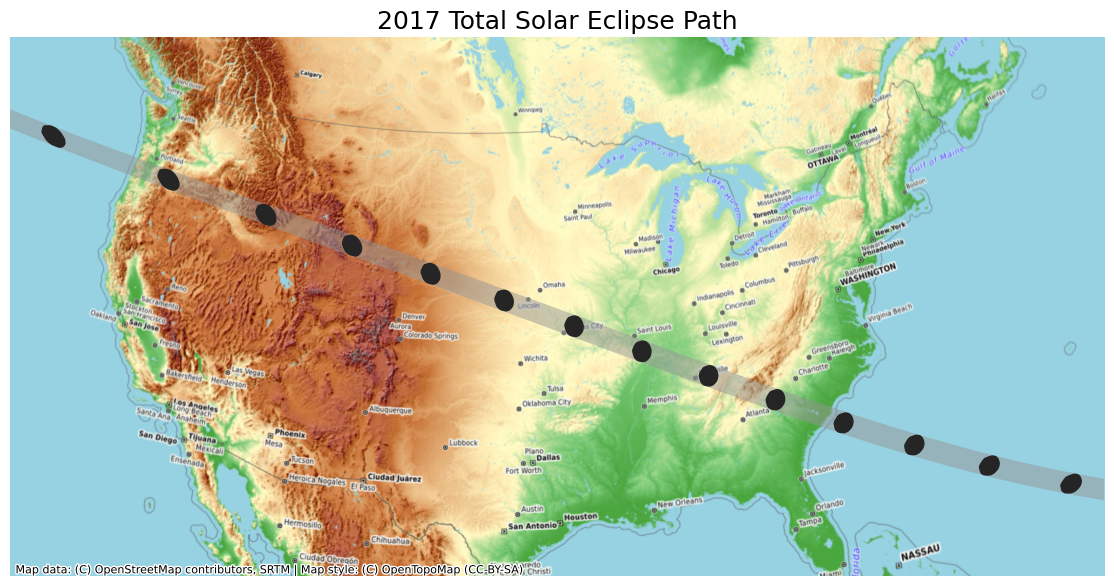

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(15,7)

# Set the bounds
ax.set_xlim(bounds[0], bounds[2])
ax.set_ylim(bounds[1], bounds[3])

path_reprojected.plot(
    ax=ax,
    facecolor='#969696',
    edgecolor='none',
    alpha=0.5)

umbra_reprojected.plot(
    ax=ax,
    facecolor='#252525',
    edgecolor='none')

cx.add_basemap(
    ax,
    crs=path_reprojected.crs,
    source=cx.providers.OpenTopoMap,
    zoom=5)

ax.set_axis_off()
ax.set_title('2017 Total Solar Eclipse Path', size = 18)

plt.show()

## Exercise

1. Our eclipse dataset also contains polygons for penumbra contours. Add them to the visualization. This layer has a column `Obscur` that contains the obscuration value (the fraction of the Sun's area covered by the Moon). Style the contours by the obscuration value and add it to the map.
2. Instead of the OpenTopoMap, create a visualization using another basemap. Some options to try are  `Esri.WorldTerrain`, `CartoDB.Positron` and `USGS.USTopo`.

<img src='https://courses.spatialthoughts.com/images/python_dataviz/eclipse_path.png' width=800/>

The code below reads and re-projects the penumbra shapefile. Start your exercise by rendering the polygons by the `Obsur` column and then add it to the main chart.

In [ ]:
penumbra_shapefile_path = os.path.join(
    data_folder, penumbra_shapefile + '.shp')
penumbra_gdf = gpd.read_file(penumbra_shapefile_path)
penumbra_reprojected = penumbra_gdf.to_crs(crs)
penumbra_reprojected